In [ ]:
import numpy as np
from scipy.io import loadmat
import os
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Conv1D,Dense,Flatten,Conv2D,MaxPooling2D,Dropout
import tensorflow as tf
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.svm import SVC

from tqdm.notebook import tqdm_notebook
from tqdm import tqdm

import re

# **Test Code**

In [ ]:
#load data

data_dir = '/content/drive/MyDrive/Sleep Apnea/Features/'
x = []
y = []
num_epoch = 687
for file in os.listdir( data_dir ):
    y.append(1 if 'Apnea' in file else 0)
    data = loadmat(data_dir + file)['feature_mtx'][:num_epoch,:]
    x.append(data)

In [ ]:
#Break into freq bands

band_id = range(5)
bands = []

for band in band_id:
    subs = []
    for sub in x:
        all = []
        for epo in sub:
            idx = 0
            freq_features = []
            while idx < 15:
                freq_features.append(epo[idx*5 + band])
                idx += 1
            all.append(freq_features)
        subs.append(all)
    bands.append(subs)

In [ ]:
X = np.array(x)
y = np.array(y)

 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

 #use the line below when training NN
#  y_train = tf.expand_dims(y_train, -1)

#use the line below when training SVC
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
model = SVC()

In [ ]:
model.fit(X_train, y_train)

SVC()

In [ ]:
# model = keras.models.Sequential()

# model.add(Conv1D(5, kernel_size=5, input_shape = (num_epoch, 75), name='Conv1D'))
# model.add(Flatten(name='Flatten'))
# model.add(Dense(1,activation='sigmoid', name='Dense'))

# model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=200)

In [ ]:
y_pred = model.predict(X_test)
y_pred = [1 if item>0.5 else 0 for item in y_pred]
accuracy_score(y_test, y_pred)

0.6875

In [ ]:
y_pred

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]

In [ ]:
y_test

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.6875

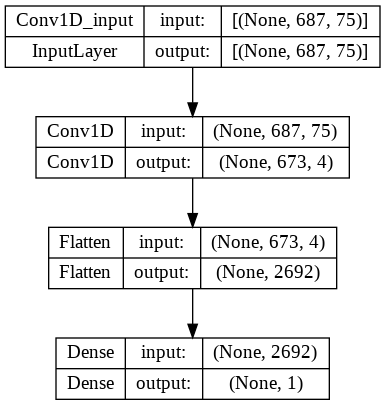

In [ ]:
from keras.utils.vis_utils import plot_model
model = conv_model(687,75)
plot_model(model, to_file='/content/drive/MyDrive/Sleep Apnea/Features/Conv1D_4.png', show_shapes=True, show_layer_names=True)

# **CNN Code (With KFold)**

In [ ]:
def load_data(desired_subs, num_epoch):
    data_dir = '/content/drive/MyDrive/Sleep Apnea/Features/'
    x = []
    y = []
    for file in os.listdir( data_dir ):
        sub_id = int(re.findall(r'\d+', file)[0])
        if sub_id in desired_subs:
            y.append(1 if 'Apnea' in file else 0)
            data = loadmat(data_dir + file)['feature_mtx'][:num_epoch,:]
            x.append(data)

    return len(x),np.array(x),np.array(y)

def extract_freq_band_features(x):
    band_id = range(5)
    bands = []

    for band in band_id:
        subs = []
        for sub in x:
            all = []
            for epo in sub:
                idx = 0
                freq_features = []
                while idx < 15:
                    freq_features.append(epo[idx*5 + band])
                    idx += 1
                all.append(freq_features)
            subs.append(all)
        bands.append(subs)

    return np.array(bands)

In [ ]:
def conv_model(num_epoch, num_features):
    model = keras.models.Sequential()
    model.add(Conv1D(4, kernel_size=15, input_shape = (num_epoch, num_features), name='Conv1D'))
    model.add(Flatten(name='Flatten'))
    model.add(Dense(1,activation='sigmoid', name='Dense'))

    model.summary()
    return model

In [ ]:
model = conv_model(num_epoch=687, num_features=15)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D (Conv1D)             (None, 673, 4)            904       
                                                                 
 Flatten (Flatten)           (None, 2692)              0         
                                                                 
 Dense (Dense)               (None, 1)                 2693      
                                                                 
Total params: 3,597
Trainable params: 3,597
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def deep_model(num_subs, num_epoch, num_features):
    model = keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=15, input_shape = (num_subs, num_epoch, num_features), name='Conv2D_1'))
    model.add(MaxPooling2D(name='Maxpooling2D_1'))
    model.add(Conv2D(32, kernel_size=15, name='Conv2D_2'))
    model.add(MaxPooling2D(name='Maxpooling2D_2'))
    model.add(Conv2D(64, kernel_size=15, name='Conv2D_3'))
    model.add(MaxPooling2D(name='Maxpooling2D_3'))
    model.add(Flatten(name='Flatten_1'))
    model.add(Dense(64, name='Dense_1'))
    model.add(Dropout(64, name='DropOut'))
    model.add(Dense(1,activation='sigmoid', name='Dense_2'))

    model.summary()
    return model




In [ ]:
deep_model(16,687,75)

In [ ]:
def kfold_train(X, y, n_splits, num_epoch=687, feature_num=75):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    acc = []
    fold_no = 1

    for train_index, test_index in kf.split(X):
        print(f'Training on fold {fold_no}')

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = conv_model(num_epoch,feature_num)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        model.fit(X_train, y_train, epochs=100, batch_size=200, verbose=1)

        y_pred = model.predict(X_test)
        y_pred = [1 if item>0.5 else 0 for item in y_pred]
        fold_acc = accuracy_score(y_test, y_pred)
        print('-----------------------------------------------------------------')
        print(f'ACCuracy:\t{fold_acc}\n')
        print('-----------------------------------------------------------------')

        acc.append(fold_acc)
        fold_no += 1
    return acc

In [ ]:
desired_subs = [1,2,5,6,7,8,9,10, 5021, 5013, 5035, 5064, 5061, 5059, 5060]
# desired_subs = [[1,2,5,6,7,8,9,10], [7,5021, 5013, 5035, 5064, 5061, 5059, 5060]]

num_subs,X,y = load_data(desired_subs,687)
band_feat = extract_freq_band_features(X)

print(f'X:\t{X.shape}\ny:\t{y.shape}\nBands:\t{band_feat.shape}')

X:	(20, 687, 75)
y:	(20,)
Bands:	(5, 20, 687, 15)


In [ ]:
t=[]
for band in range(5):
    print(f"Baaandddd:\t{band}")
    acc = kfold_train(band_feat[band],y,n_splits=num_subs,feature_num=15)
    # print(sum(acc)/len(acc))
    # print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    # print(sum(acc)/len(acc))
    # print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n')
    t.append(sum(acc)/len(acc))

Streaming output truncated to the last 5000 lines.
Epoch 76/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0158
Epoch 77/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0154
Epoch 78/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0149
Epoch 79/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0145
Epoch 80/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0141
Epoch 81/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0138
Epoch 82/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0134
Epoch 83/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0130
Epoch 84/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0127
Epoch 85/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0124
Epoch 86/100
1/1 [==============================] - 0s 26ms/step - loss: 0.0121
Epoch 87/100
1/1 [==============================] - 0s 26ms/step - lo

In [ ]:
acc = kfold_train(X,y,n_splits=num_subs)

Training on fold 1
Epoch 1/100
1/1 [==============================] - 1s 573ms/step - loss: 0.7179
Epoch 2/100
1/1 [==============================] - 0s 66ms/step - loss: 0.7000
Epoch 3/100
1/1 [==============================] - 0s 66ms/step - loss: 0.6199
Epoch 4/100
1/1 [==============================] - 0s 77ms/step - loss: 0.6015
Epoch 5/100
1/1 [==============================] - 0s 73ms/step - loss: 0.5398
Epoch 6/100
1/1 [==============================] - 0s 69ms/step - loss: 0.5341
Epoch 7/100
1/1 [==============================] - 0s 68ms/step - loss: 0.4581
Epoch 8/100
1/1 [==============================] - 0s 68ms/step - loss: 0.4468
Epoch 9/100
1/1 [==============================] - 0s 67ms/step - loss: 0.3740
Epoch 10/100
1/1 [==============================] - 0s 74ms/step - loss: 0.3688
Epoch 11/100
1/1 [==============================] - 0s 66ms/step - loss: 0.2996
Epoch 12/100
1/1 [==============================] - 0s 65ms/step - loss: 0.2906
Epoch 13/100
1/1 [===========

In [ ]:
#whole acc
sum(acc)/len(acc)

0.9

In [ ]:
#freq band acc
for acc in t:
    print(f'{acc}')

0.85
0.85
0.8
0.75
0.85


# **SVM Code (With LeaveOneSubjectOut Validation)**

In [ ]:
def svm_load_data(desired_subs, num_epoch):
    data_dir = '/content/drive/MyDrive/Sleep Apnea/Features/'
    x = []
    y = []
    for file in os.listdir( data_dir ):
        sub_id = int(re.findall(r'\d+', file)[0])
        label = 1 if 'Apnea' in file else 0
        if sub_id in desired_subs[label]:
            # print(f'{sub_id}_{label}')
            y.append(1 if 'Apnea' in file else 0)
            data = loadmat(data_dir + file)['feature_mtx'][:num_epoch,:]
            x.append(data)

    return len(x),np.array(x),np.array(y)

def svm_extract_freq_band_features(x):
    band_id = range(5)
    bands = []

    for band in band_id:
        subs = []
        for sub in x:
            all = []
            for epo in sub:
                idx = 0
                freq_features = []
                while idx < 15:
                    freq_features.append(epo[idx*5 + band])
                    idx += 1
                all.append(freq_features)
            subs.append(all)
        bands.append(subs)

    return np.array(bands)

In [ ]:
def svm_loo_train(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    acc = []
    fold_no = 1

    for train_index, test_index in tqdm(kf.split(X)):
        # print(f'Training on fold {fold_no}')

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        model = SVC()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = [1 if item>0.5 else 0 for item in y_pred]
        fold_acc = accuracy_score(y_test, y_pred)

        acc.append(fold_acc)
        fold_no += 1
    return acc

In [ ]:
desired_subs = [[1,2,5,6,7,8,9,10], [7,5021, 5013, 5035, 5064, 5061, 5059, 5060]]

num_subs,X,y = svm_load_data(desired_subs, 687)
band_feat = svm_extract_freq_band_features(X)

print(f'X:\t{X.shape}\ny:\t{y.shape}\nBands:\t{band_feat.shape}')

5_0
6_0
1_0
2_0
5013_1
5021_1
5035_1
7_1
7_0
8_0
5059_1
5060_1
5061_1
5064_1
9_0
10_0
X:	(16, 687, 75)
y:	(16,)
Bands:	(5, 16, 687, 15)


In [ ]:
band_acc=[]
for band in range(5):
    print(f"++++++++++++++++++\nTesting on Band:\t{band}\n")
    acc = svm_loo_train(band_feat[band],y,num_subs)

    band_acc.append(sum(acc)/len(acc))

++++++++++++++++++
Testing on Band:	0



16it [00:00, 317.52it/s]


++++++++++++++++++
Testing on Band:	1



16it [00:00, 400.62it/s]


++++++++++++++++++
Testing on Band:	2



16it [00:00, 417.94it/s]


++++++++++++++++++
Testing on Band:	3



16it [00:00, 284.91it/s]


++++++++++++++++++
Testing on Band:	4



16it [00:00, 304.95it/s]


In [ ]:
#freq band acc
for acc in band_acc:
    print(f'{acc}')

0.875
0.75
0.4375
0.0
1.0


In [ ]:
whole_acc = svm_loo_train(X,y,num_subs)

16it [00:00, 79.71it/s]


In [ ]:
#whole bands acc
sum(whole_acc)/len(whole_acc)

0.4375

# **Base Model:(CONV-1D)**

1. [according to this article, columns should be time steps](https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610 )

2. [Epoch Vs Batch size](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20batch%20size%20is%20a,passes%20through%20the%20training%20dataset)

3. [loss and activation function](https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8 )

4. [Optimizer](https://ai.stackexchange.com/questions/18206/what-kind-of-optimizer-is-suggested-to-use-for-binary-classification-of-similar)

5. [Pooling?](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/)
